# Predicting Insurance Costs

This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

We're interested in how these different characteristics relate to the total medical cost. We want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

The dataset is available [here](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download). 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load in the dataset
insurance = pd.read_csv('insurance.csv')

## Exploring the Dataset

In [3]:
# What columns are present?
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


(array([536., 398., 129.,  86.,  35.,  59.,  57.,  32.,   2.,   4.]),
 array([ 1121.8739  ,  7386.729311, 13651.584722, 19916.440133,
        26181.295544, 32446.150955, 38711.006366, 44975.861777,
        51240.717188, 57505.572599, 63770.42801 ]),
 <BarContainer object of 10 artists>)

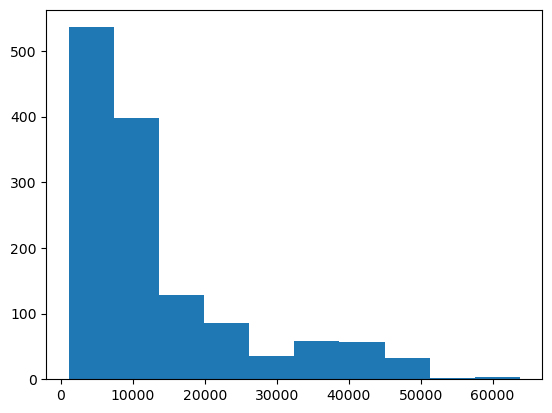

In [33]:
# Explore the outcome with visualisation
plt.hist(insurance['charges'])

In [34]:
insurance['charges'].mean()

13270.422265141257

In [36]:
insurance['charges'].max()

63770.42801

In [37]:
insurance['charges'].median()

9382.033

In [4]:
# Check the values of the categorical columns
smoker_freq = insurance['smoker'].value_counts()
smoker_freq

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
sex_freq = insurance['sex'].value_counts()
sex_freq

male      676
female    662
Name: sex, dtype: int64

In [6]:
reg_freq = insurance['region'].value_counts()
reg_freq

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Columns are a mix of categorical and numeric data and don't have any null values. We can convert two of the three categorical columns into numeric quite easily. The third, "region", will need to be split into dummy variables for future work.   

In [7]:
# Turn "sex" into numeric
insurance['sex'] = insurance['sex'].apply(lambda x: 0 if x == "male" else 1)
insurance['sex'].value_counts()

0    676
1    662
Name: sex, dtype: int64

In [8]:
# Turn "smoker" into numeric
insurance['smoker'] = insurance['smoker'].apply(lambda x: 0 if x == "no" else 1)
insurance['smoker'].value_counts()

0    1064
1     274
Name: smoker, dtype: int64

In [9]:
# Create dummy variables
dum = pd.get_dummies(insurance['region'],drop_first=True)
insurance_dum = pd.concat([insurance,dum], axis=1)
insurance_dum = insurance_dum.drop('region', axis=1)

We are looking to understand total medical cost so the 'charges' column is our outcome. We'll start to get a sense of its relationship with the predictors by doing some correlation. 

In [10]:
# Check correlation
corrs = insurance_dum.corr()
corrs

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
age,1.000000,0.020856,0.109272,0.042469,-0.025019,0.299008,-0.000407,-0.011642,0.010016
sex,0.020856,1.000000,-0.046371,-0.017163,-0.076185,-0.057292,0.011156,-0.017117,0.004184
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,0.198341,-0.135996,0.270025,-0.006205
children,0.042469,-0.017163,0.012759,1.000000,0.007673,0.067998,0.024806,-0.023066,0.021914
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,0.787251,-0.036945,0.068498,-0.036945
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,1.000000,-0.039905,0.073982,-0.043210
northwest,-0.000407,0.011156,-0.135996,0.024806,-0.036945,-0.039905,1.000000,-0.346265,-0.320829
southeast,-0.011642,-0.017117,0.270025,-0.023066,0.068498,0.073982,-0.346265,1.000000,-0.346265
southwest,0.010016,0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320829,-0.346265,1.000000


<Axes: >

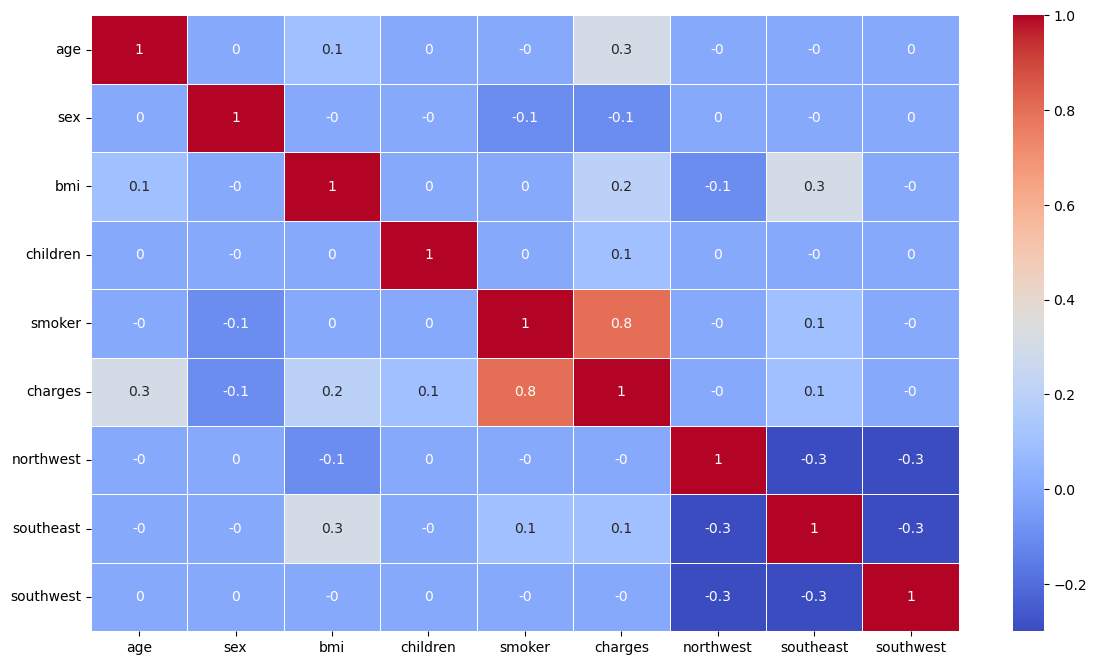

In [11]:
# Heatmap the correlation
plt.figure(figsize=(14, 8))
sns.heatmap(round(corrs,1), 
            xticklabels=corrs.columns, 
            yticklabels=corrs.columns,
            cmap='coolwarm', # Choose a colormap that represents the correlation scale
            annot=True, # Show correlation values
            linewidths=.5) # Line widths between squares

There is a strong positive correlation between "smoker" and the outcome. No other predictors correlate highly with each other.

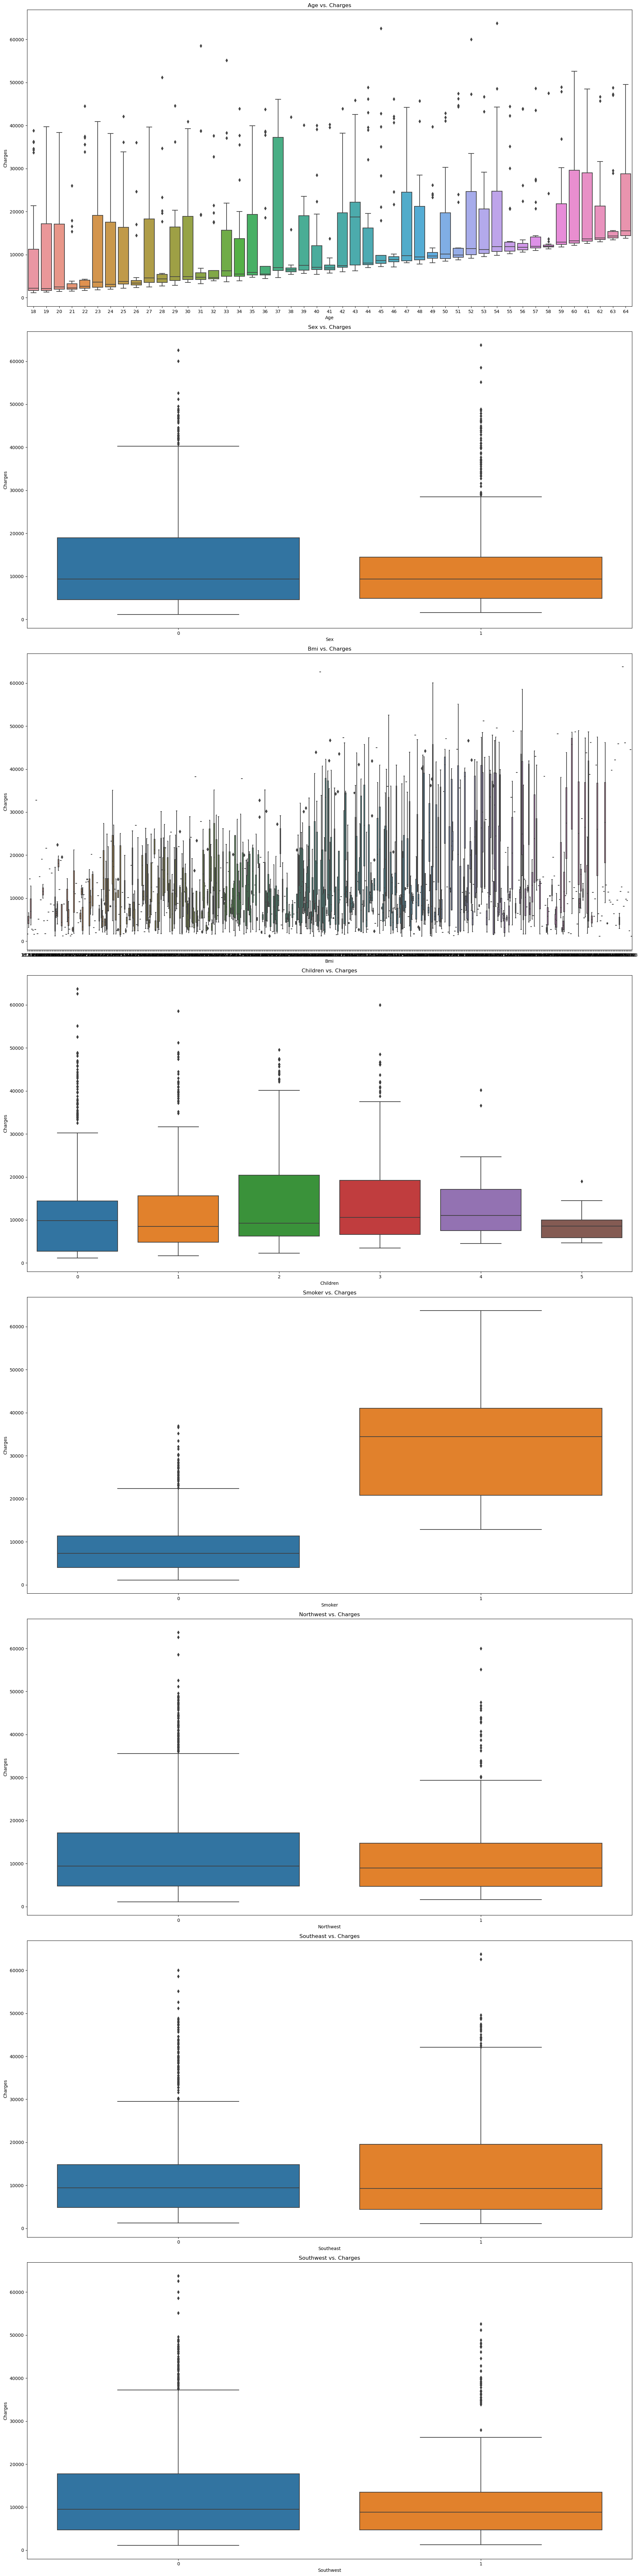

In [12]:
# Check the relationships between the potential predictor variables with the outcome via plots

# List all predictors; assuming all columns except 'charges' are predictors
predictors = insurance_dum.columns.drop('charges')

# Setting up the plotting area; creating a figure with multiple axes
fig, axes = plt.subplots(len(predictors), 1, figsize=(20, 10 * len(predictors)))  # Adjust height per subplot as needed

# Ensure axes is an array even if there's only one subplot
if len(predictors) == 1:
    axes = [axes]

for i, predictor in enumerate(predictors):
    # Boxplot for each predictor vs. charges
    sns.boxplot(ax=axes[i], x=predictor, y='charges', data=insurance_dum)
    axes[i].set_title(f'{predictor.capitalize()} vs. Charges')
    axes[i].set_xlabel(predictor.capitalize())
    axes[i].set_ylabel('Charges')

plt.tight_layout()
plt.show()

It does appear that there might be some stratifying effects on some predictors - age and BMI. I'm going to run correlation on the subsets that seem to be more effected. 

In [13]:
# Filter the dataset
insurance_older = insurance_dum[(insurance_dum['age'] > 40)]

# Re-run correlation
corrs2 = insurance_older.corr()
corrs2

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
age,1.000000,0.010179,0.077492,-0.247125,-0.034930,0.176324,0.011549,-0.012288,0.001124
sex,0.010179,1.000000,-0.027641,0.001953,-0.078985,-0.064808,0.021311,-0.025991,-0.000846
bmi,0.077492,-0.027641,1.000000,0.039180,-0.015960,0.159351,-0.138142,0.225298,0.011068
children,-0.247125,0.001953,0.039180,1.000000,0.029033,0.041962,0.030143,0.025920,-0.017803
smoker,-0.034930,-0.078985,-0.015960,0.029033,1.000000,0.819512,-0.000218,0.117953,-0.108311
charges,0.176324,-0.064808,0.159351,0.041962,0.819512,1.000000,-0.020806,0.137941,-0.110154
northwest,0.011549,0.021311,-0.138142,0.030143,-0.000218,-0.020806,1.000000,-0.341949,-0.321553
southeast,-0.012288,-0.025991,0.225298,0.025920,0.117953,0.137941,-0.341949,1.000000,-0.347830
southwest,0.001124,-0.000846,0.011068,-0.017803,-0.108311,-0.110154,-0.321553,-0.347830,1.000000


In [14]:
insurance_older['age'].min()

41

In [15]:
# Filter the dataset
insurance_hibmi = insurance_dum[(insurance_dum['bmi'] > 40)]

# Re-run correlation
corrs2 = insurance_hibmi.corr()
corrs2

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
age,1.000000,-0.081522,-0.094458,0.136852,-0.021444,0.208681,0.049264,-0.009925,0.049263
sex,-0.081522,1.000000,-0.073648,0.028346,-0.117226,-0.075618,0.115994,-0.189076,0.081349
bmi,-0.094458,-0.073648,1.000000,0.141115,0.044529,0.031784,-0.222783,0.239744,0.058341
children,0.136852,0.028346,0.141115,1.000000,0.076850,0.100913,0.220522,-0.072523,0.064440
smoker,-0.021444,-0.117226,0.044529,0.076850,1.000000,0.948330,-0.077938,0.176431,-0.149071
charges,0.208681,-0.075618,0.031784,0.100913,0.948330,1.000000,-0.020709,0.134605,-0.146465
northwest,0.049264,0.115994,-0.222783,0.220522,-0.077938,-0.020709,1.000000,-0.383739,-0.126745
southeast,-0.009925,-0.189076,0.239744,-0.072523,0.176431,0.134605,-0.383739,1.000000,-0.504608
southwest,0.049263,0.081349,0.058341,0.064440,-0.149071,-0.146465,-0.126745,-0.504608,1.000000


The effect doesn't seem to stand up to further investigation, i.e. it is just a linear effect, but we will still include them as predictors for now. 

Final predictor choice: Smoking, age and BMI. They were chosen for the moderate to strong correlations with the outcome. Given domain knowlege about health and these factors, they make sense to use. People develop greater helath conditions with age. Smoking is well known to lead to health problems. BMI is an index used to measure obesity and obesity is associated with increased health problems and lifestyles that are generally less conducive to good health. health problems are going to lead to increased medical care which in turn will lead to greater risk for the insurance company and hence greater charges to cover the risk.   

## Building the Model

In [16]:
# Separate the outcome from the predictors
X = insurance_dum.drop('charges',axis=1)
y = insurance_dum['charges']

# Dividing the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 729)


In [17]:
# Filter for relevant predictors
X_train_subset = X_train[['age','smoker','bmi']]

# Create and fit the model
model = LinearRegression()
model.fit(X_train_subset,y_train)

# Examine aspects of the model
train_cfs = model.coef_
train_cfs

array([  259.02068399, 24375.66154526,   336.63883672])

In [18]:
# Predicting
train_predictions = model.predict(X_train_subset)

# Calculating the mean squared error
train_mse = mean_squared_error(y_train, train_predictions)
train_mse

38168673.83913308

In [19]:
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_rmse

6178.080109478436

In [20]:
# Calculating coefficient of determination 
train_r2 = r2_score(y_train, train_predictions)
train_r2

0.751048499031778

The model's coefficients suggest that the "smoker" predictor is by far and away the most influential. This is no surprise given the difference in correlation between it and the other predictors. It makes me question whether I should just remove the other predictors. The issue then is that we have a model built only on one predictor that is increasingly less prevalent (["Current smoking has declined from 20.9%...in 2005 to 11.5% (nearly 12 of every 100 adults) in 2021."](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm)).  

The coefficient of determination suggests that 75% of the variance in the predictions are covered by the predictors. This seems reasonable but I'm interested in seeing if that really is the case and if further refinement is possible. 

## Residual Diagnostics

We now have a working predictive model for medical costs! Before we examine it more closely, we should check how well the assumptions of linear regression are met.

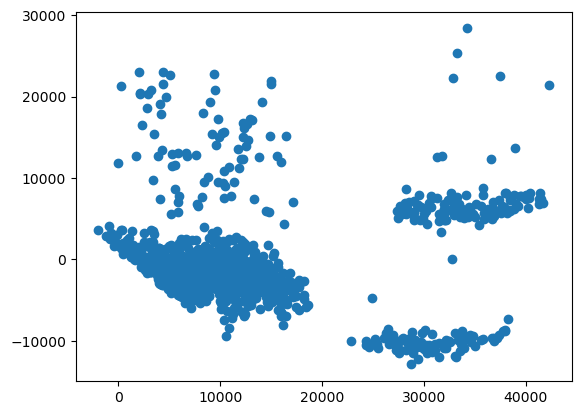

In [21]:
# Use calculated values to calculate the residuals of the model
residuals = y_train - train_predictions

# Plot the residuals against the preditions on a graph
plt.scatter(train_predictions,residuals)
plt.show()

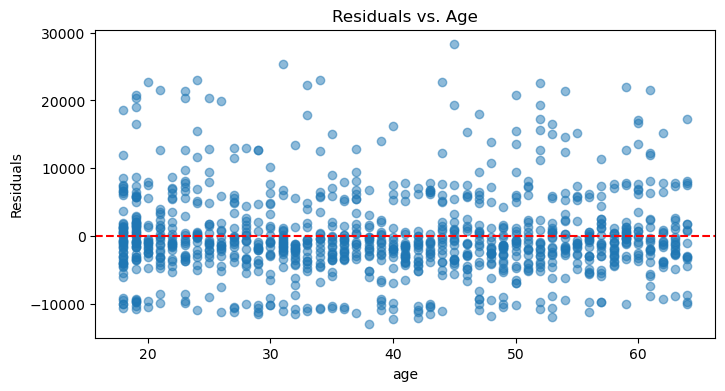

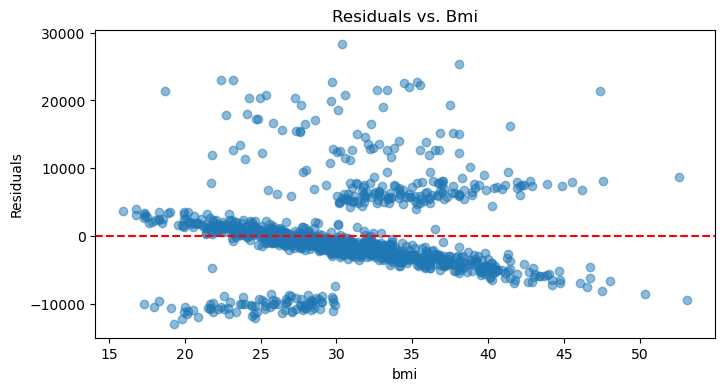

In [32]:
# Check for relationships between the individual predictors and the outcome with visualisation
for predictor in X_train_subset[['age','bmi']]:
    plt.figure(figsize=(8, 4))
    plt.scatter(X_train_subset[predictor], residuals, alpha=0.5)
    plt.title(f'Residuals vs. {predictor.capitalize()}')
    plt.xlabel(predictor)
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

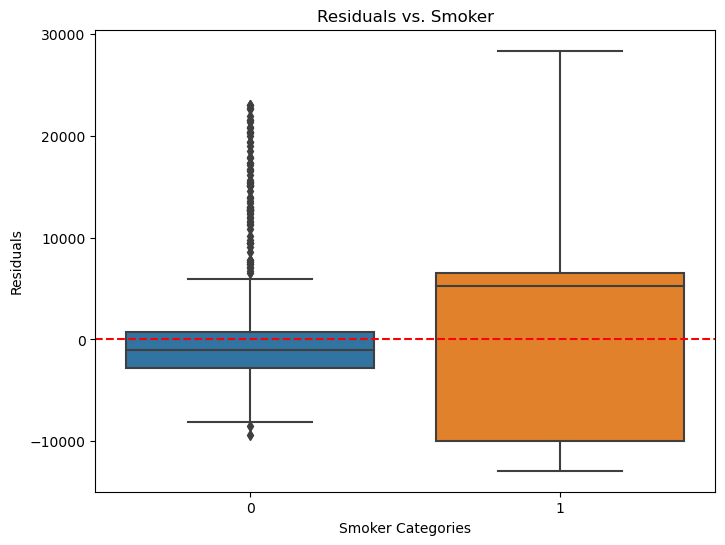

In [23]:
# Boxplotting the categorical predictor differently to avoid issues
plt.figure(figsize=(8, 6))
sns.boxplot(x=X_train_subset['smoker'], y=residuals)
plt.title('Residuals vs. Smoker')
plt.xlabel('Smoker Categories')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()

#### Do the residuals seem to center around 0 over the range of the fitted values?

There is a large cluster around 0 but there are 3 other clusters. One at -10,000 and another +10,000. The third cluster isn't as clustered but it sits between +8,000 and +23,000. 

#### Do the residuals seem to remain in a constant "band" around 0 over the range of fitted values? If not, what does the trend look like?

The residuals are not remaining in a constant band around 0. A lot, maybe the majority do, but as described above, there are three other clusters of residuals. 

#### Do the residuals seem to trend with any of the predictors in the model?

The BMI predictor seems to have a pattern with residuals. While non-smokers are well covered by the model, smokers are  not. There is a lot of variance. 

The constant variance assumption isn't holding. It feels like we are potentially dealing with some non-linearity here. 

## Interpreting the Model

In [24]:
# Find the intercept
intercept = model.intercept_
intercept

-12009.281942025596

The intercept doesn't have a meaningful interpretation. Age and BMI are not able to have zero values in this instance.The presence of dummy variables can also make interpretation less meaningful. 

For a linear model with multiple predictors, we would interpret B1 coefficient as the average increase in Y for a unit increase in X1, holding the other predictors constant. This applies to each coefficient. 

In my model, for example, costs are increased by 259 for every year of age, holding other predictors consistent. 

## Final Model Evaluation

Now we can fit the model to the test data. 

In [29]:
# Filter for relevant predictors
X_test_subset = X_test[['age','smoker','bmi']]

# Run predictions on the test data
test_predictions = model.predict(X_test_subset)

# Calculate the mean squared error
test_mse = mean_squared_error(y_test, test_predictions)
test_mse

32825992.551507592

In [30]:
# Calculate the mean squared error
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_rmse

5729.3972240984995

Our test MSE is slightly less than our training MSE which is good as it can indicate a better fit of the model to the data. 

In [31]:
# Calculating coefficient of determination 
test_r2 = r2_score(y_test, test_predictions)
test_r2

0.7230005665005681

# Conclusions

The model accounts for 72% of the variation of charges which I believe to be a reasonable result. From what we know about smoking, obesity and age, it makes perfect sense that these are effective predictors of health related charges. Given the coverage of the charge variation, the model does predict insurance losses better. 

The RMSE of \\$5729 makes sense in the context of the data. The mean charge is over \\$13,000, the median over \\$9,000  and the max more than \\$63,000. THis would be a useful number for an insurance company to use.  